In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import math
import seaborn as sns
import math

from scipy.spatial.distance import pdist, cdist,squareform
from scipy import linalg

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn import datasets
import scipy.sparse as sp
from sklearn.datasets import make_circles, make_moons, make_blobs, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

FUNCTION FOR SPECTRAL CLUSTERING WITH CUSTOM IMPLEMENTATION

In [2]:
def spectral_clustering(dataframe, similarity_graph, laplacian, number_of_clusters, eps=None, k=None):

    # Pairwise distances
    dimension = dataframe.shape[0]
    dist_mat = squareform(pdist(dataframe))

    sample_size = len(dist_mat)
    
    # Set n based on proportional selection, but limit by log scaling for large datasets
    n = min(sample_size // 10, int(math.log(sample_size)))

    # Fallback values for epsilon and k
    epsilon = eps if eps else np.percentile(dist_mat, 90)
    k = k if k else int(np.sqrt(sample_size))
    
    if similarity_graph == "full":

        #calculate local sigma
        sigmas = np.zeros(dimension)
        for i in tqdm(range(len(dist_mat))):
            sigmas[i] = np.partition(dist_mat[i], n)[n]

        # Adjaceny matrix with optimal sigma
        adjacency_matrix = np.zeros([dimension, dimension])
        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):  
                d = np.exp(-1*dist_mat[i, j]**2/(sigmas[i]*sigmas[j]))
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d

    
    elif similarity_graph == "eps":

        # Adjaceny matrix with epsilon threshold
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):
                if dist_mat[i, j] < epsilon:
                    d = 1
                else:
                    d = 0
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d


    elif similarity_graph == "knn":

        # Adjaceny matrix with k-neighbours
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself
        
            # Update the adjacency matrix
            adjacency_matrix[i, k_nearest_indices] = 1


    else:

        # Adjaceny matrix with mutual k-neighbours
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself
        
            for neighbor in k_nearest_indices:
                # Check if node i is also among the k-nearest neighbors of the current neighbor
                neighbor_sorted_indices = np.argsort(dist_mat[neighbor])
                if i in neighbor_sorted_indices[1:k+1]:
                    # Connect nodes if they are mutual k-nearest neighbors
                    adjacency_matrix[i, neighbor] = 1
                    adjacency_matrix[neighbor, i] = 1

    # # Calculate the degree matrix
    # dimension = len(adjacency_matrix)
    # degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

    # # Identify isolated nodes (degree = 0)
    # isolated_nodes = np.where(np.diag(degree_matrix) == 0)[0]
    # non_isolated_mask = np.isin(np.arange(dimension), isolated_nodes, invert=True)

    # # Handle non-isolated nodes only for clustering
    # adjacency_matrix_non_isolated = adjacency_matrix[non_isolated_mask][:, non_isolated_mask]
    # degree_matrix_non_isolated = degree_matrix[non_isolated_mask][:, non_isolated_mask]

    # if laplacian == "sym":

    #     # Normalized Symmetric laplacian matrix
    #     d_half = linalg.fractional_matrix_power(degree_matrix_non_isolated, -0.5)
    #     laplacian_matrix_normalized = d_half @ adjacency_matrix_non_isolated @ d_half
    # if laplacian == "rw":

    #     # Normalized Random Walk laplacian matrix
    #     d_inverse = linalg.fractional_matrix_power(degree_matrix_non_isolated, -1)
    #     laplacian_matrix_normalized = d_inverse @ adjacency_matrix_non_isolated


    # if laplacian == "ad":
        
    #     # Adaptive Laplacian matrix
    #     degree_vector = np.diag(degree_matrix_non_isolated)
    #     D_local = np.zeros_like(degree_vector)
        
    #     for i in range(len(degree_vector)):
    #         neighbors = np.where(adjacency_matrix_non_isolated[i] > 0)[0]
    #         if len(neighbors) > 0:
    #             D_local[i] = np.sum(adjacency_matrix_non_isolated[neighbors]) / degree_vector[i]
    #         else:
    #             D_local[i] = 0
        
    #     D_local_matrix = np.diag(D_local)
    #     D_local_inv = linalg.fractional_matrix_power(D_local_matrix, -0.5)
    #     laplacian_matrix_normalized = D_local_inv @ adjacency_matrix_non_isolated @ D_local_inv

    # Calculate degree matrix
    degrees = np.sum(adjacency_matrix, axis=1)
    degree_matrix = np.diag(degrees)

    if laplacian == "sym":

        # Normalized Symmetric laplacian matrix
        d_inv_sqrt = np.zeros_like(degrees)
        nonzero = degrees > 0
        d_inv_sqrt[nonzero] = 1.0 / np.sqrt(degrees[nonzero])
        d_half = np.diag(d_inv_sqrt)
        laplacian_matrix_normalized = d_half @ adjacency_matrix @ d_half

    if laplacian == "rw":

        # Normalized Random Walk laplacian matrix
        d_inv = np.zeros_like(degrees)
        nonzero = degrees > 0
        d_inv[nonzero] = 1.0 / degrees[nonzero]
        d_inverse = np.diag(d_inv)
        laplacian_matrix_normalized = d_inverse @ adjacency_matrix

    if laplacian == "ad":

        # Adaptive Laplacian matrix
        D_local = np.zeros_like(degrees)
        for i in range(len(degrees)):
            neighbors = np.where(adjacency_matrix[i] > 0)[0]
            if len(neighbors) > 0 and degrees[i] > 0:
                D_local[i] = np.sum(degrees[neighbors]) / degrees[i]
            else:
                D_local[i] = 0
        D_local_inv_sqrt = np.zeros_like(D_local)
        nonzero = D_local > 0
        D_local_inv_sqrt[nonzero] = 1.0 / np.sqrt(D_local[nonzero])
        D_local_inv = np.diag(D_local_inv_sqrt)
        laplacian_matrix_normalized = D_local_inv @ adjacency_matrix @ D_local_inv
    
    if check_symmetric(laplacian_matrix_normalized) :
        # Calculating eigenvalues and eigenvectors for symmetric matrix
        e, v = np.linalg.eigh(laplacian_matrix_normalized)
    else:
        # Calculating eigenvalues and eigenvectors for non-symmetric matrix
        e, v = np.linalg.eig(laplacian_matrix_normalized)
        idx = np.argsort(np.real(e))
        e = np.real(e[idx])
        v = np.real(v[:, idx]) 
    
    # Calculate eigengap
    eigengap = np.diff(e)
    optimal_number_of_clusters = np.argmax(eigengap[:10]) + 1   
    
    # Use k=2 for circles and moons, eigengap for others
    if number_of_clusters == "fixed2":
        current_k = 2  # For circles and moons
    elif number_of_clusters == "fixed3":
        current_k = 3  # For circles and moons:
    else:
        current_k = max(optimal_number_of_clusters,2)

    results = []
    
    # Perform clustering on the non-isolated nodes
    X = v[:, -current_k:]
    clustering = KMeans(n_clusters=current_k, random_state=42, n_init = 100)
    cluster_labels = clustering.fit_predict(X)
    sil_score = silhouette_score(dataframe, cluster_labels)
    # non_isolated_labels = clustering.labels_

    # # Full label assignment
    # full_labels = np.full(dimension, -1)
    # full_labels[non_isolated_mask] = non_isolated_labels

    # # Assign isolated nodes based on nearest non-isolated neighbors
    # if len(isolated_nodes) > 0:
    #     isolated_points = dataframe[isolated_nodes]

    #     # Calculate distances to non-isolated points in original space
    #     non_isolated_points = dataframe[non_isolated_mask]
    #     distances_to_non_isolated = cdist(isolated_points, non_isolated_points)

    #     # Assign labels based on the closest non-isolated point
    #     nearest_non_isolated_indices = np.argmin(distances_to_non_isolated, axis=1)
    #     isolated_labels = full_labels[non_isolated_mask][nearest_non_isolated_indices]
    #     full_labels[isolated_nodes] = isolated_labels
    return [(current_k, cluster_labels,sil_score)]

In [3]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [4]:
# Random seed for reproducibility
np.random.seed(0)

# Hyperparameters
default_base = {
    'quantile': .3,
    'eps': .3,
    'damping': .9,
    'preference': -200,
    'n_neighbors': 10,
    'n_clusters': 3,
    'min_samples': 20,
    'xi': 0.05,
    'min_cluster_size': 0.1
}

# Number of samples
n_samples = 1500

# Function to generate data in the shape of given text
def make_letter_shape(text, n_samples=1500, noise=0.2):
    from sklearn.datasets import make_blobs
    # Generate initial large blob
    centers = [(0, 0)]
    cluster_std = [1.5]
    X, _ = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std)
    
    # Letter masks
    mask_E = (X[:, 0] < 0) & (X[:, 1] > -10)
    mask_v = (X[:, 0]**2 + X[:, 1]**2 < 20**2) & (X[:, 1] < 0)
    mask_i = (X[:, 0] > 0) & (X[:, 1] > -10)
    
    # Apply masks to create letters E, v, i
    X[mask_E | mask_v | mask_i] += np.random.normal(scale=noise, size=(mask_E | mask_v | mask_i).sum()).reshape(-1, 1)
    return X, np.zeros((X.shape[0],))  # Labels not used

# Generate custom shaped data
letter_shape = make_letter_shape("Evi", n_samples=n_samples, noise=0.05)

# Pre-existing dataset configurations
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = (np.random.rand(n_samples, 2), None)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# Blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# Generate random sparse dataset
n_features = 1500
density = 0.01
X_sparse = sp.random(n_samples, n_features, density=density, format='csr', random_state=0)
X_sparse_dense = X_sparse.toarray()
y_sparse = np.random.randint(0, 3, size=n_samples)

# Full configuration list
datasets_with_params = [
    (noisy_circles, {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2, 'min_samples': 20, 'xi': 0.25, 'dataset_name': 'Noisy Circles'}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2, 'dataset_name': 'Noisy Moons'}),
    (varied, {'eps': .18, 'n_neighbors': 2, 'min_samples': 5, 'xi': 0.035, 'n_clusters': 3, 'dataset_name': 'Varied Blobs'}),
    (aniso, {'eps': .15, 'n_neighbors': 2, 'min_samples': 20, 'xi': 0.1, 'n_clusters': 3, 'dataset_name': 'Anisotropic Blobs'}),
    (blobs, {'n_clusters': 3, 'dataset_name': 'Blobs'}),
    (no_structure, {'dataset_name': 'No Structure'}),
    (letter_shape, {'dataset_name': 'Evi Shape'})
]

# Similarity graph types and Laplacian types
similarity_graphs = ["full", "eps", "knn", "mknn"]
laplacians = ["sym", "rw", "ad"]

In [5]:
# Function to plot spectral clustering results and aggregate results
def plot_spectral_clustering_with_additional_datasets():
    results_list = []  # Initialize the results list

    # Iterate over datasets and hyperparameters
    for dataset, params in datasets_with_params:
        X, y_true = dataset

        # Standardize the dataset
        X = StandardScaler().fit_transform(X)

        # Create a figure for the plots
        fig, axs = plt.subplots(len(similarity_graphs), len(laplacians), figsize=(20, 16))
        fig.suptitle(f"Spectral Clustering for {params.get('dataset_name', 'Dataset')}", fontsize=20)

        for i, similarity_graph in enumerate(similarity_graphs):
            for j, laplacian in enumerate(laplacians):
                # Determine number of clusters
                if params.get('n_clusters', 'eigengap') == 2:
                    num_clusters = "fixed2"
                elif params.get('n_clusters', 'eigengap') == 3:
                    num_clusters = "fixed3"
                else:
                    num_clusters = "eigengap"

                # Run spectral clustering
                result = spectral_clustering(X, similarity_graph, laplacian, num_clusters, eps=params.get('eps'), k=params.get('n_neighbors'))
                current_k, labels, sil_score = result[0]

                # Append results to the list
                results_list.append((
                    params.get('dataset_name', 'Dataset'),  # Dataset name
                    similarity_graph,                       # Similarity graph
                    laplacian,                              # Laplacian type
                    sil_score,                              # Silhouette score
                    current_k,                              # Number of clusters
                    num_clusters,                           # Hyperparameter setting
                    labels                                  # Cluster labels
                ))

                # Plot clustering results
                ax = axs[i, j]
                scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
                ax.set_title(f"{similarity_graph} - {laplacian}\n(k={current_k}, Sil: {sil_score:.2f})", fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])

        # Adjust layout for each dataset
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()  # Show plots for the current dataset

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results_list, columns=[
        "dataset", "graph", "laplacian", "silhouette", 
        "number_of_clusters", "hyperparameters", "cluster_labels"
    ])
    results_df["graph_laplacian"] = results_df["graph"] + "_" + results_df["laplacian"]

    # Return the aggregated results as a DataFrame
    return results_df

100%|██████████████████████████████████████| 1500/1500 [00:06<00:00, 226.11it/s]


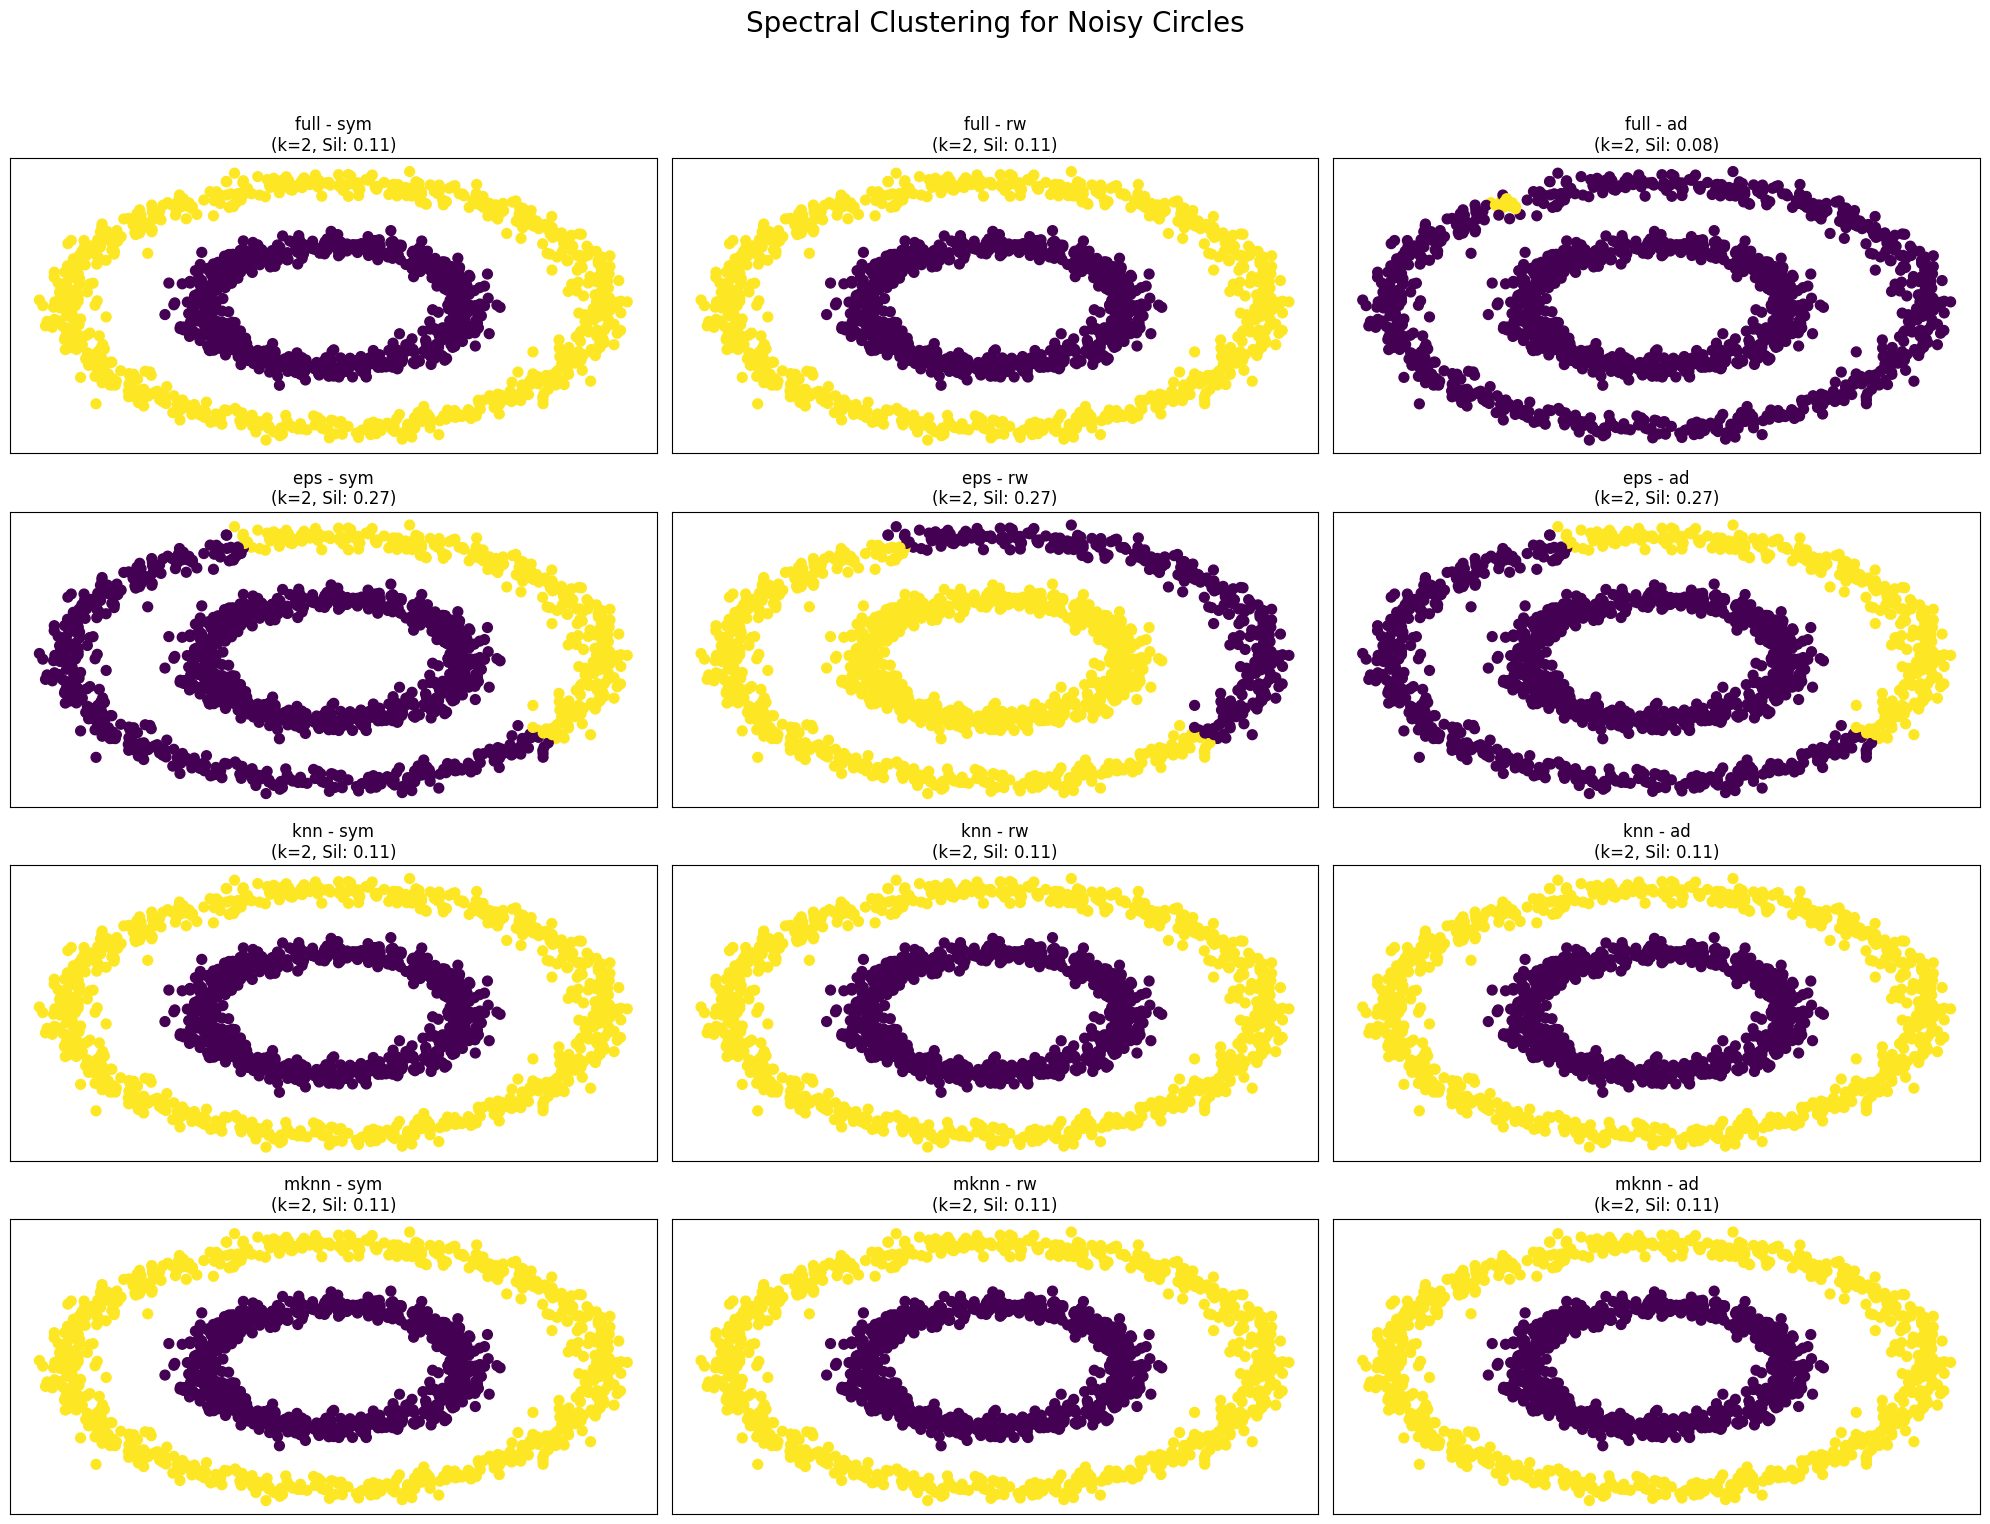

100%|██████████████████████████████████████| 1500/1500 [00:06<00:00, 228.42it/s]


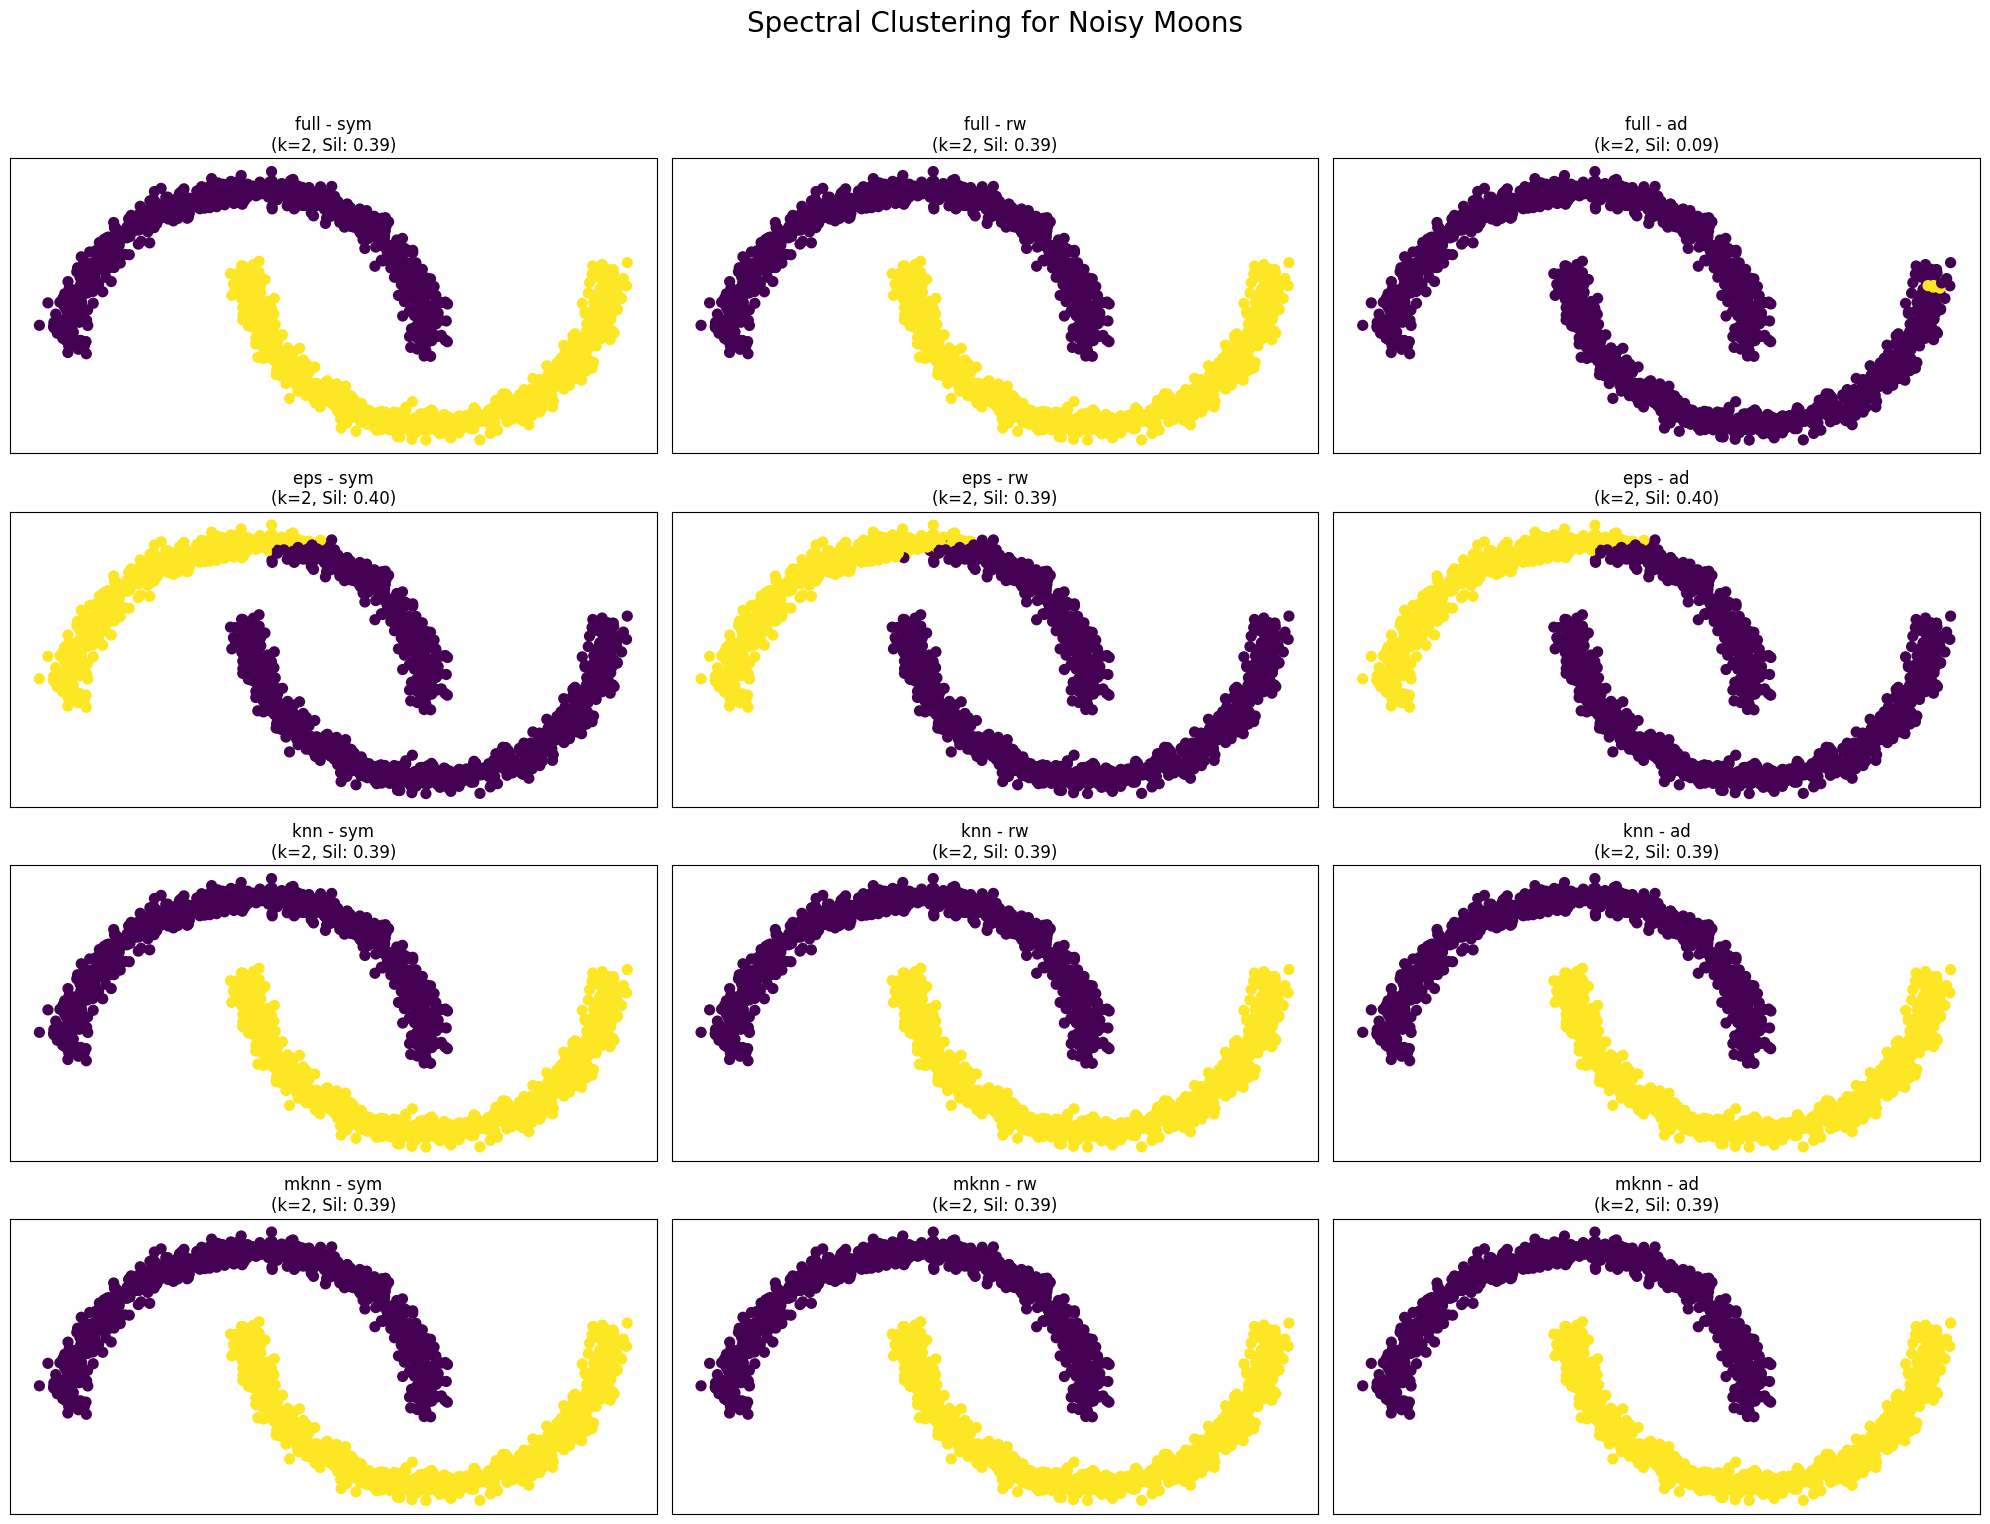

100%|█████████████████████████████████████| 1500/1500 [00:00<00:00, 2911.39it/s]


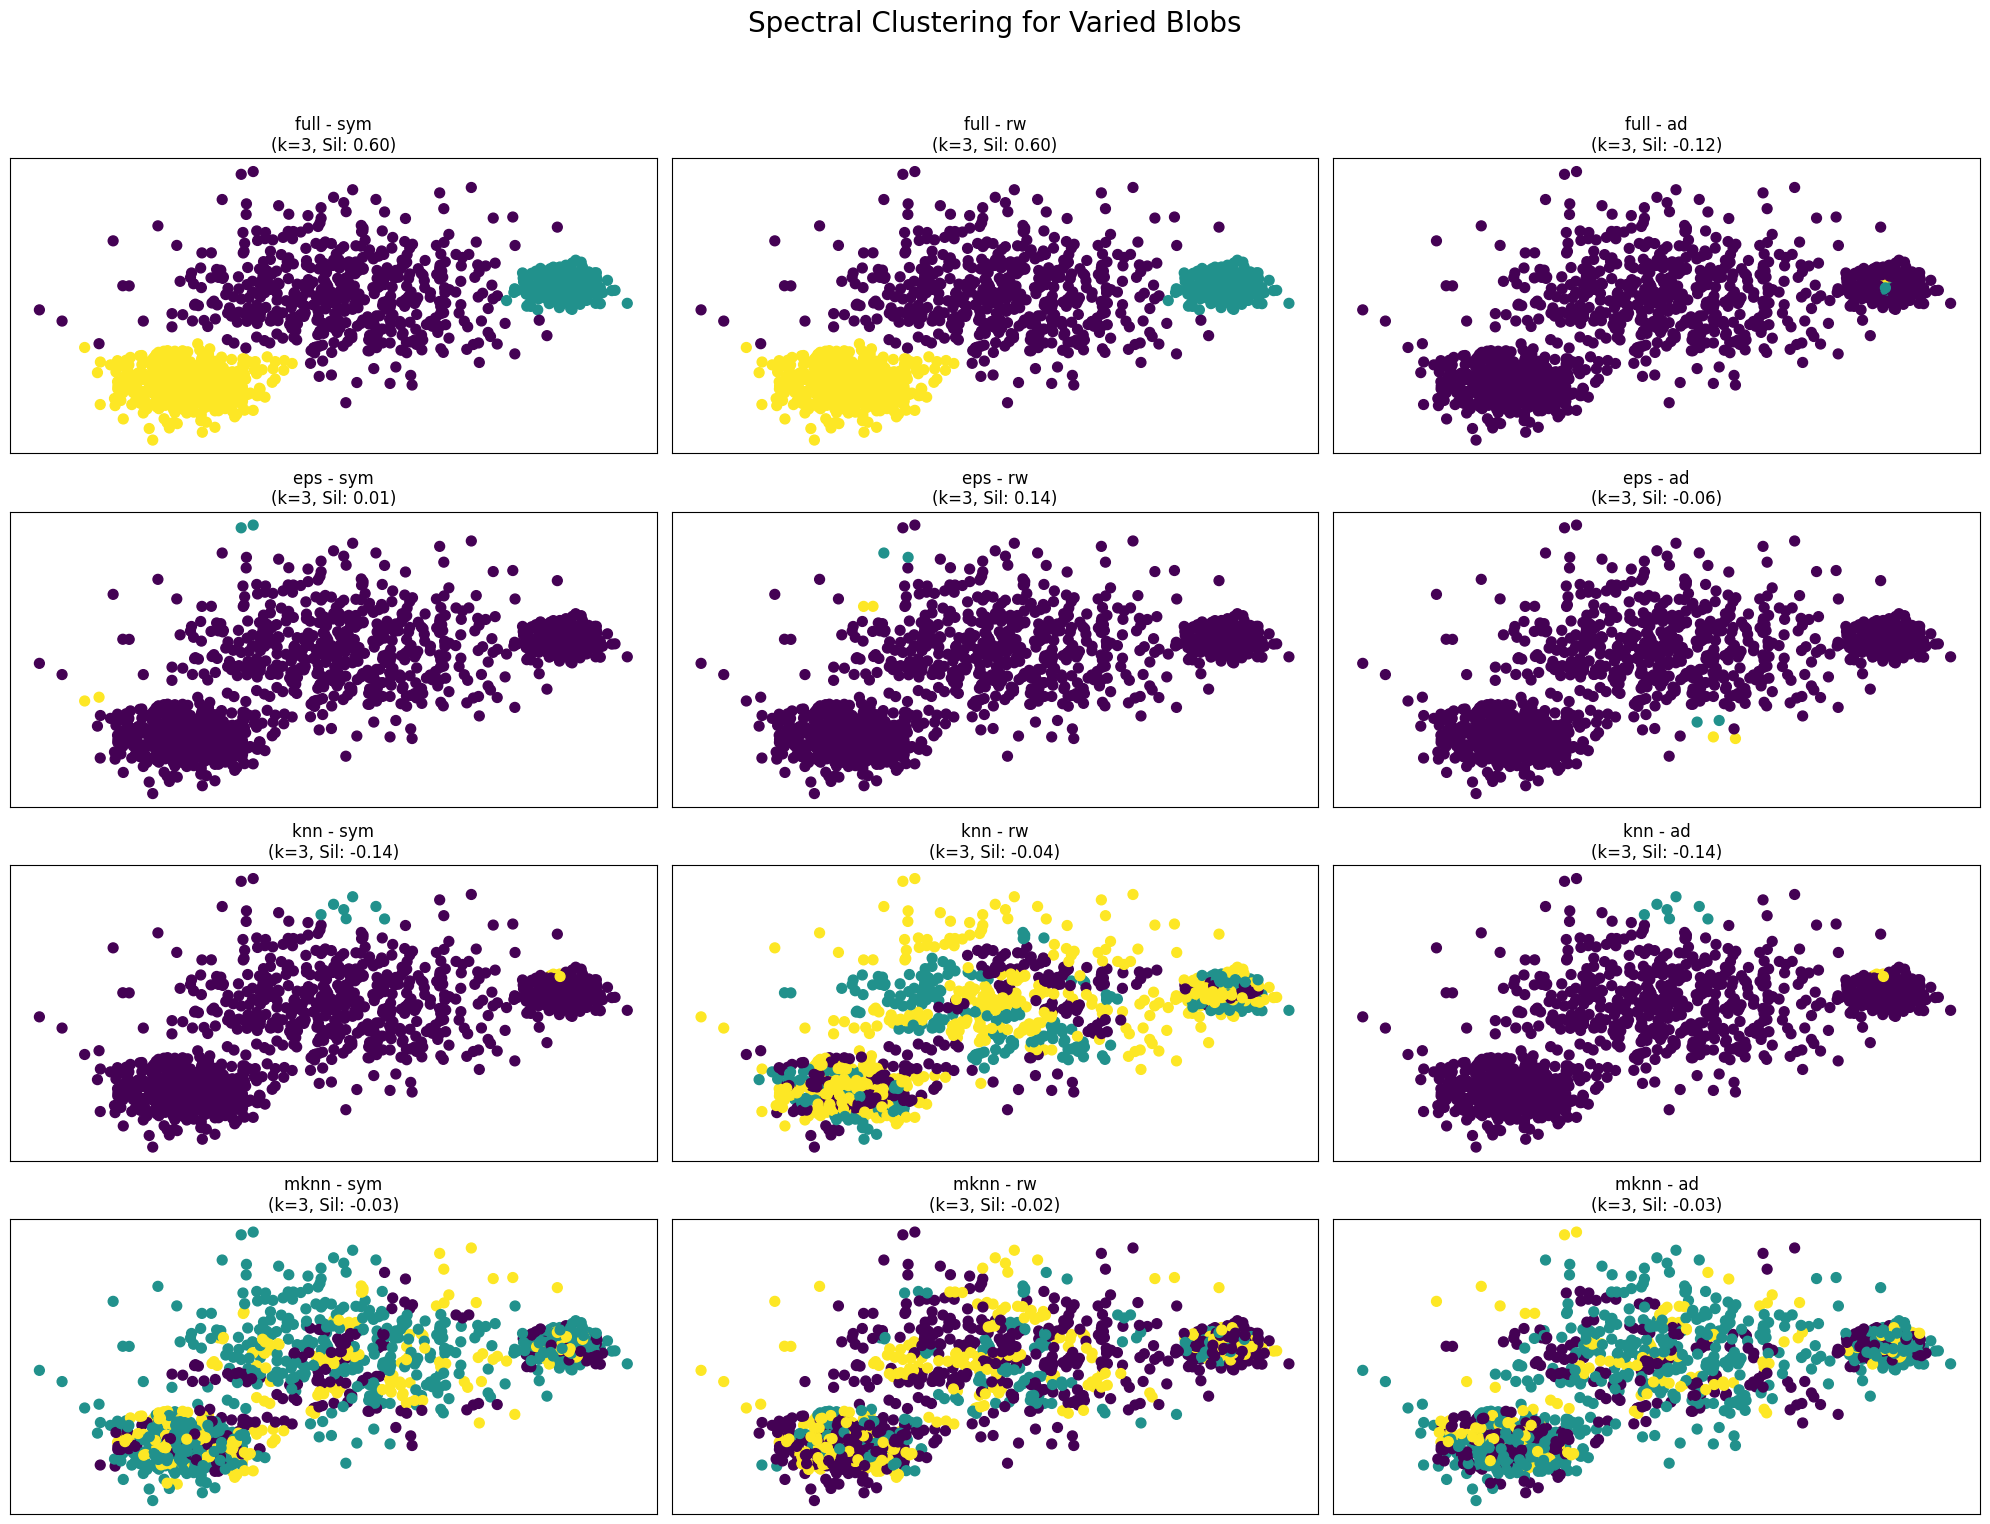

100%|█████████████████████████████████████| 1500/1500 [00:00<00:00, 2933.14it/s]


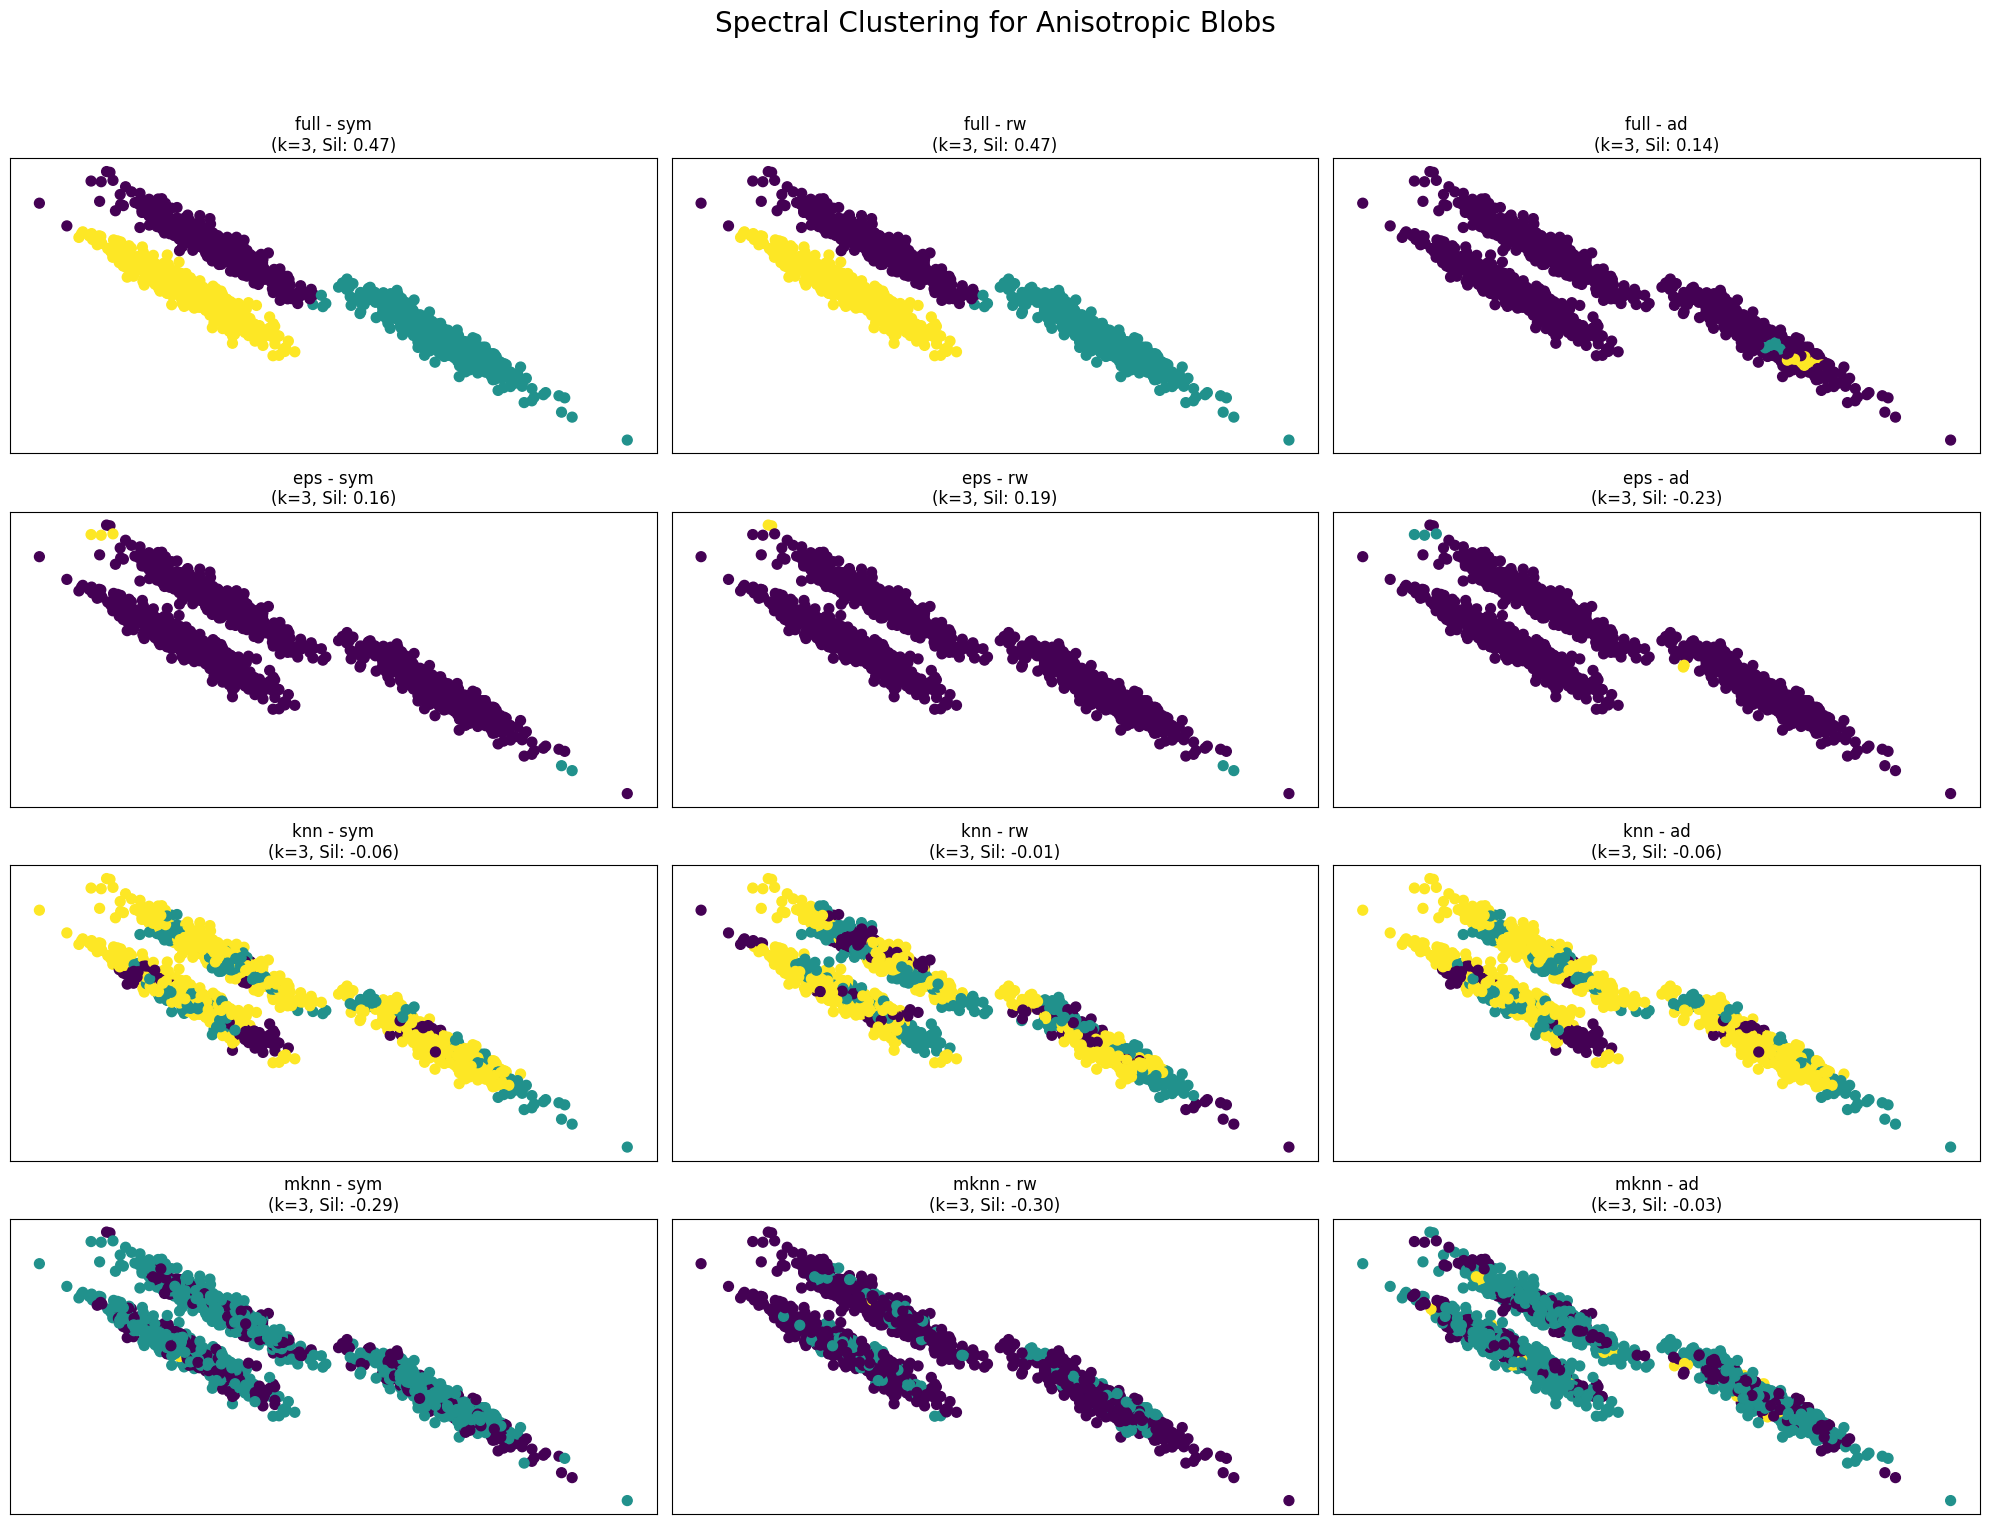

100%|██████████████████████████████████████| 1500/1500 [00:06<00:00, 238.96it/s]


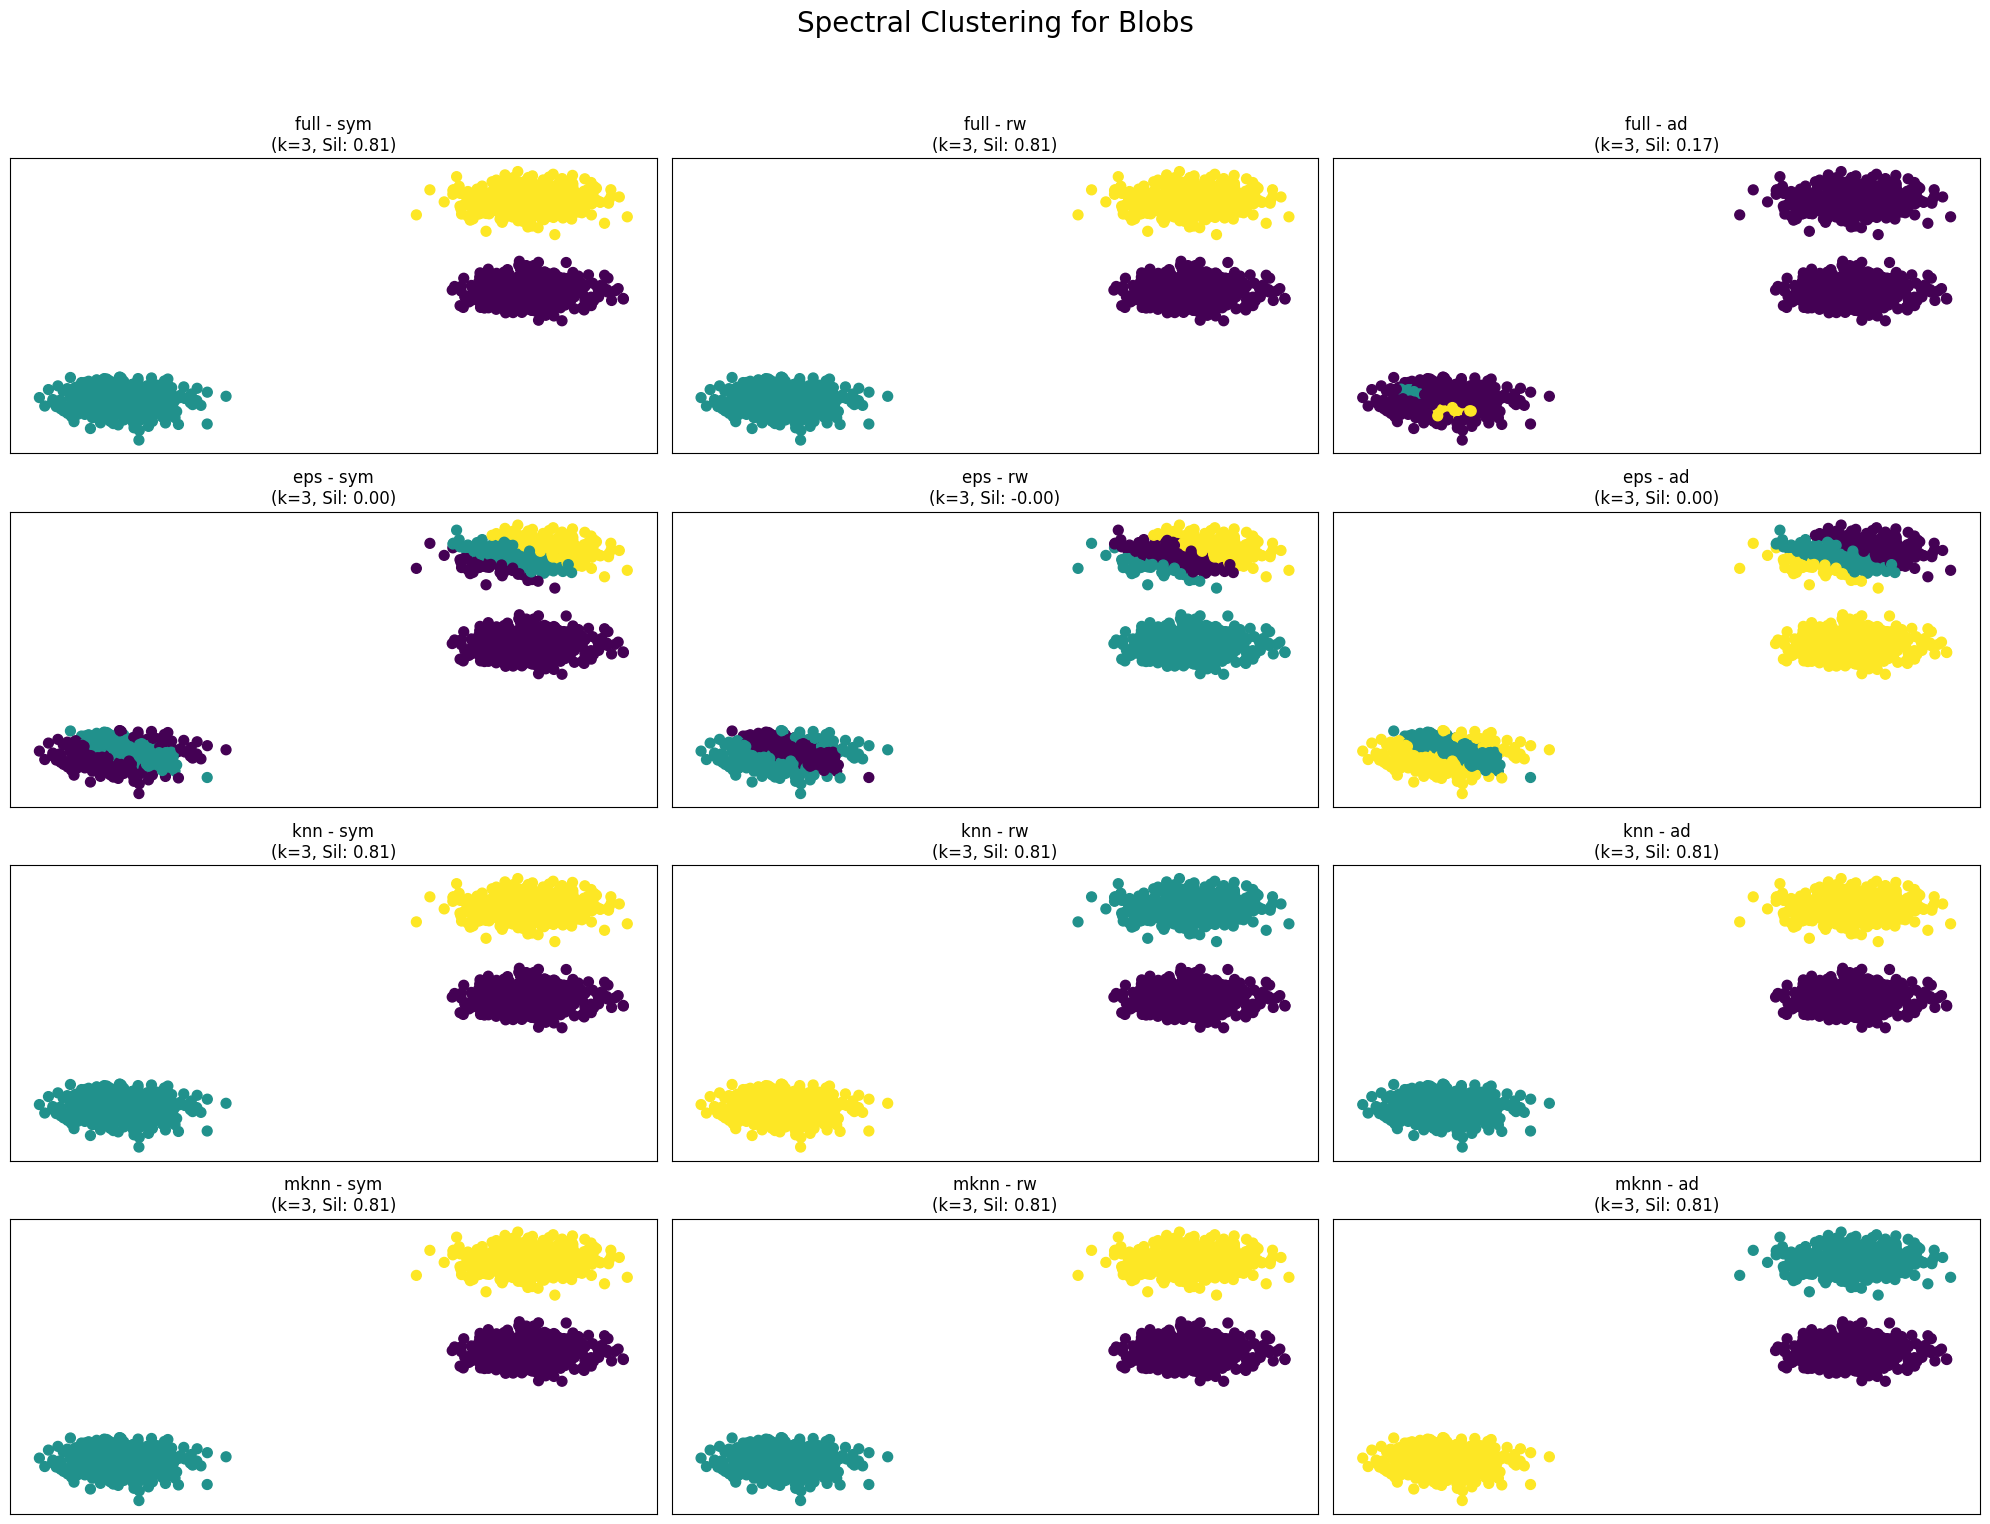

100%|██████████████████████████████████████| 1500/1500 [00:06<00:00, 226.68it/s]


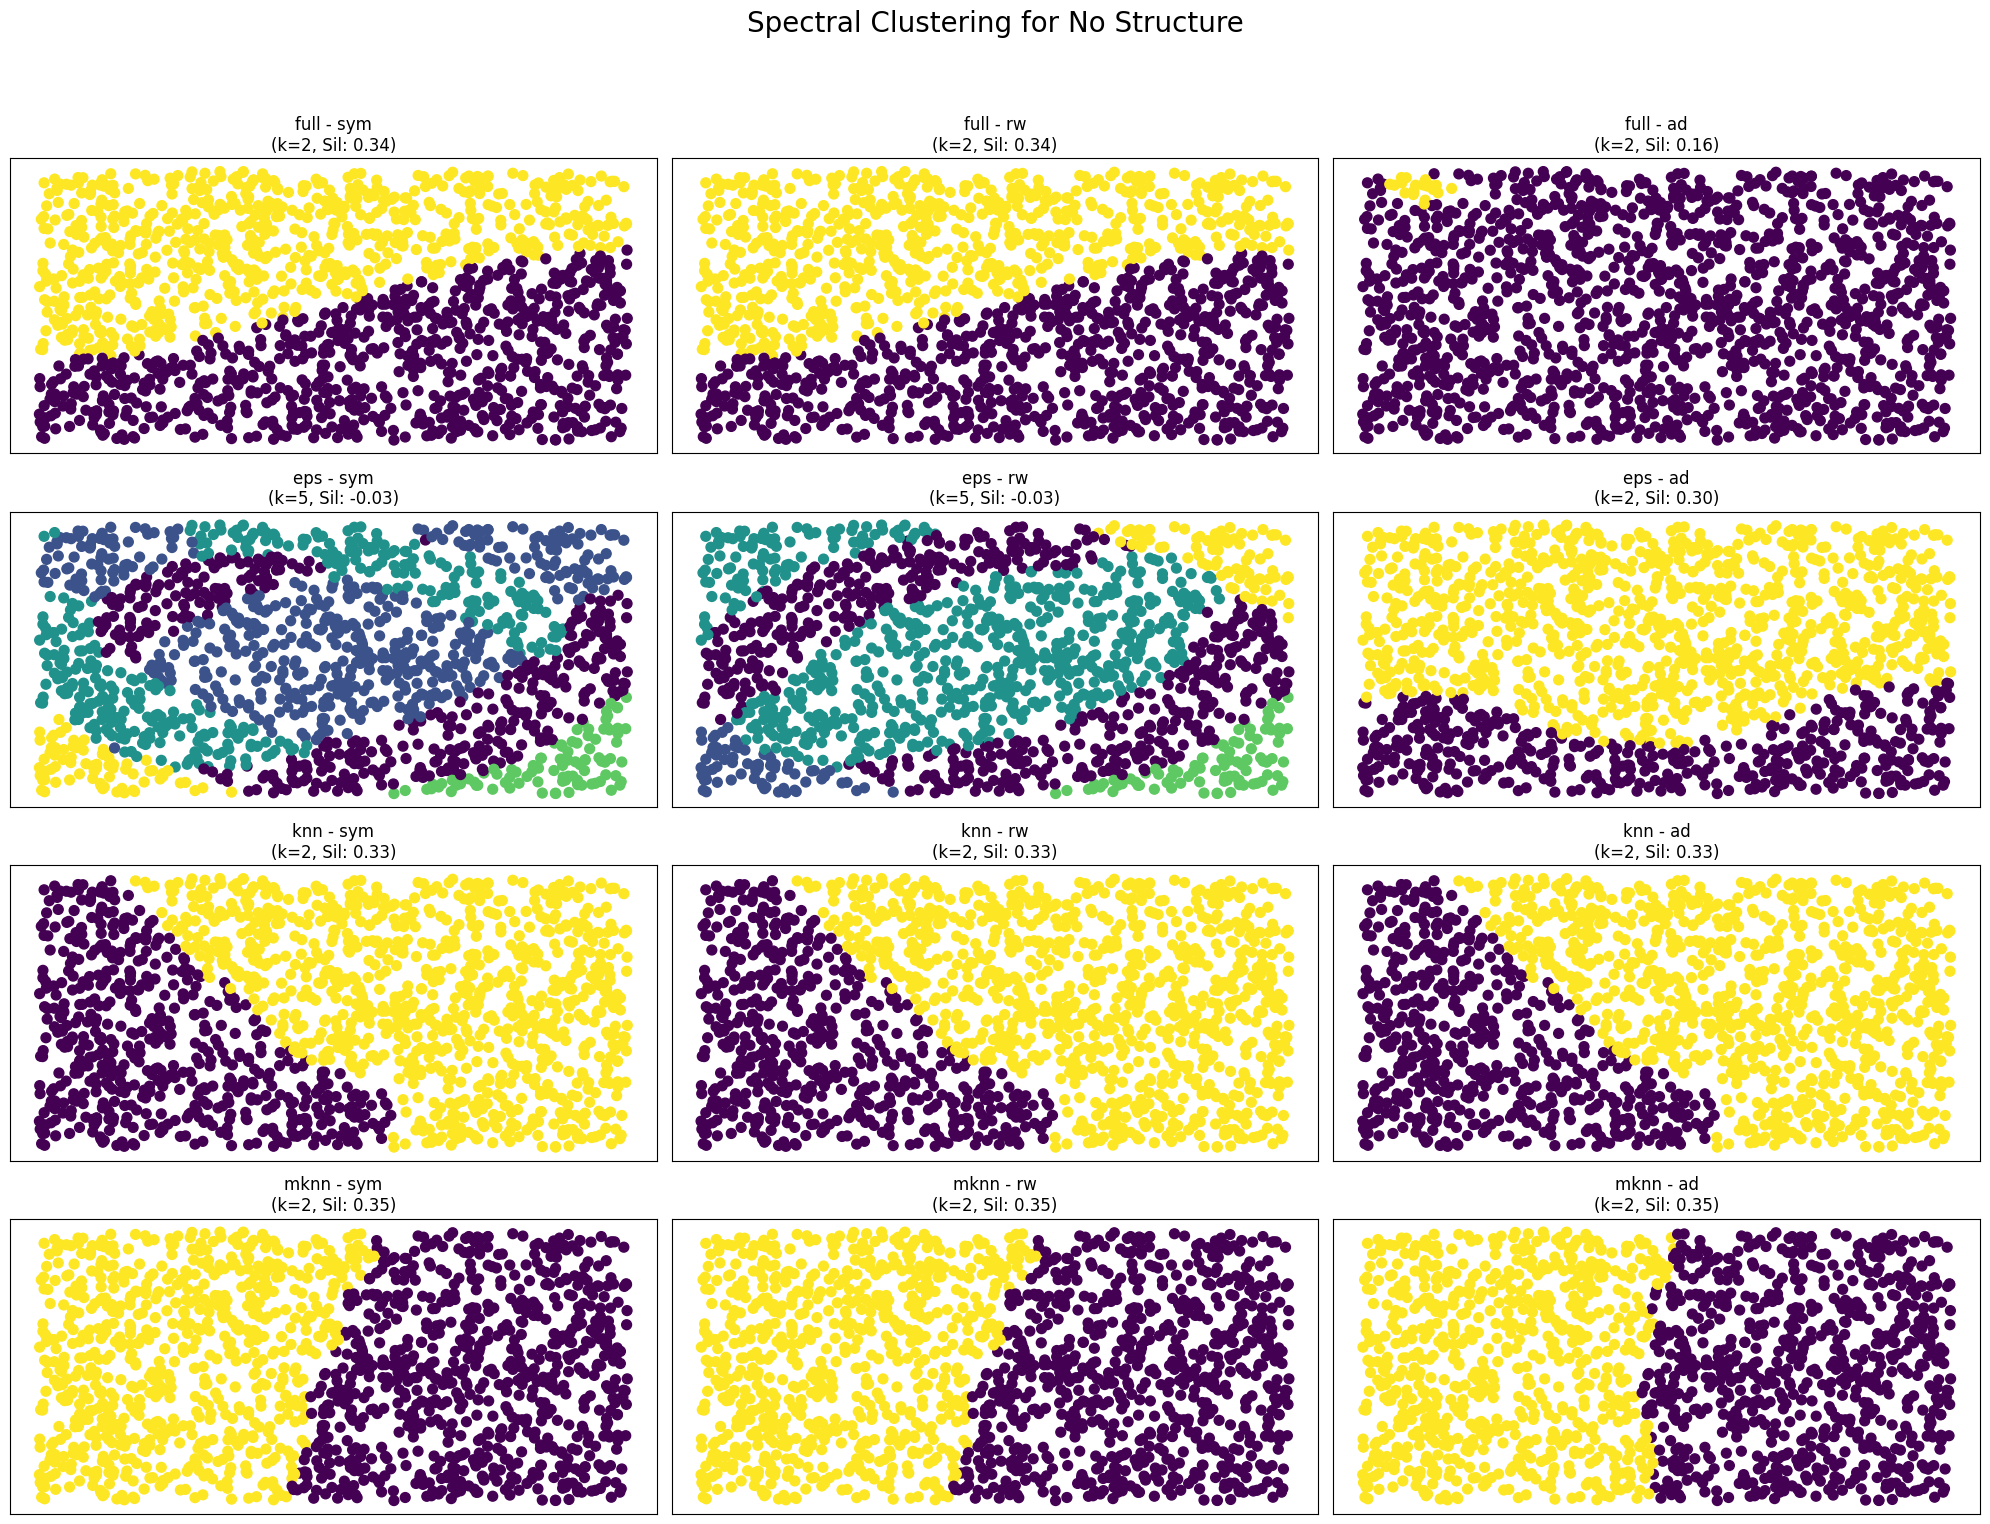

100%|██████████████████████████████████████| 1500/1500 [00:06<00:00, 231.22it/s]


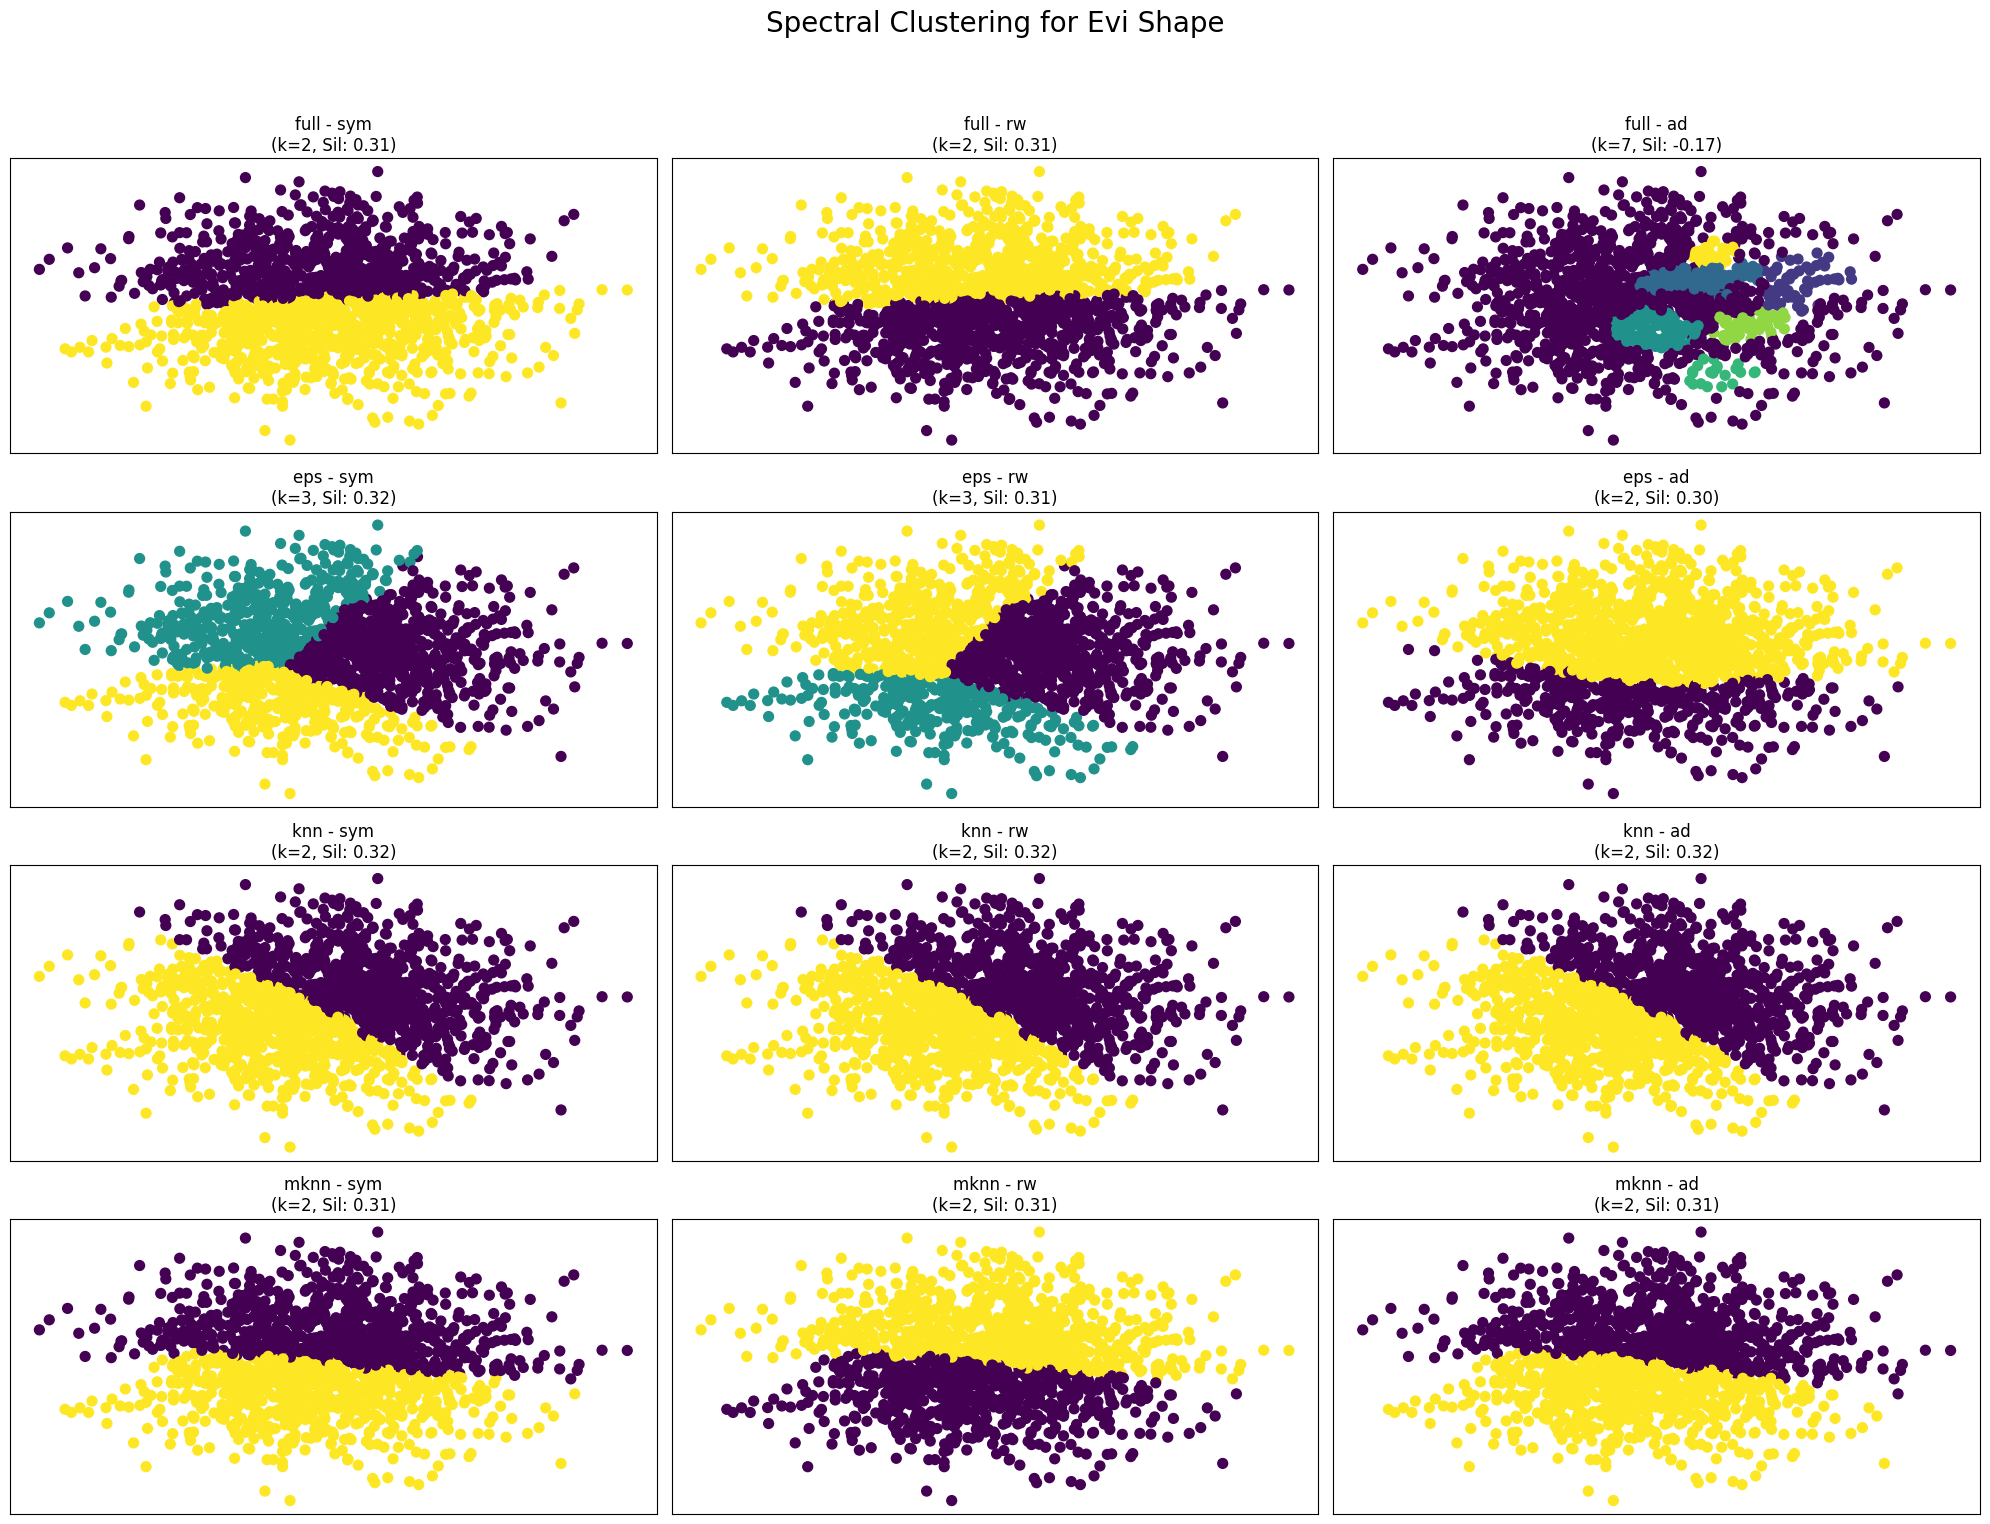

dataset graph laplacian  silhouette  number_of_clusters  \
0   Noisy Circles  full       sym    0.114821                   2   
1   Noisy Circles  full        rw    0.114821                   2   
2   Noisy Circles  full        ad    0.081498                   2   
3   Noisy Circles   eps       sym    0.271301                   2   
4   Noisy Circles   eps        rw    0.271584                   2   
..            ...   ...       ...         ...                 ...   
79      Evi Shape   knn        rw    0.315924                   2   
80      Evi Shape   knn        ad    0.315924                   2   
81      Evi Shape  mknn       sym    0.306304                   2   
82      Evi Shape  mknn        rw    0.306344                   2   
83      Evi Shape  mknn        ad    0.305869                   2   

   hyperparameters                                     cluster_labels  \
0           fixed2  [0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, ...   
1           fixed2  [0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, ...   
2           fixed2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3           fixed2  [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...   
4           fixed2  [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...   
..             ...                                                ...   
79        eigengap  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...   
80        eigengap  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...   
81        eigengap  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...   
82        eigengap  [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, ...   
83        eigengap  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...   

   graph_laplacian  
0         full_sym  
1          full_rw  
2          full_ad  
3          eps_sym  
4           eps_rw  
..             ...  
79          knn_rw  
80          knn_ad  
81        mknn_sym  
82         mknn_rw  
83         mknn_ad  

[84 rows x 8 columns]

In [6]:
experiment_results = plot_spectral_clustering_with_additional_datasets()
experiment_results